In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sys
import os
import warnings
warnings.filterwarnings('ignore')
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch.nn.functional as F

In [2]:
twitts_train = pd.read_csv("../data/twitter_training.csv")
twitts_valid = pd.read_csv("../data/twitter_validation.csv")

In [3]:
column_name=['tweetID','entity','sentiment','tweet_content']
twitts_train.columns=column_name
twitts_valid.columns=column_name
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# clean the duplicated tweets
twitts_train = twitts_train.drop_duplicates(subset=['tweet_content'])
twitts_valid = twitts_valid.drop_duplicates(subset=['tweet_content'])

# clean the empty tweets
twitts_train = twitts_train.dropna(subset=['tweet_content'])
twitts_valid = twitts_valid.dropna(subset=['tweet_content'])

# lower case the sentiment labels
twitts_train['sentiment'] = twitts_train['sentiment'].str.lower()
twitts_valid['sentiment'] = twitts_valid['sentiment'].str.lower()

# Reset index after cleaning
twitts_train.reset_index(drop=True, inplace=True)
twitts_valid.reset_index(drop=True, inplace=True)

print("Number of tweets in training set after cleaning:", len(twitts_train))
print("Number of tweets in validation set after cleaning:", len(twitts_valid))
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# Remove the irrelevant sentiment label
twitts_train = twitts_train[twitts_train['sentiment'].isin(['positive', 'negative', 'neutral'])]
twitts_valid = twitts_valid[twitts_valid['sentiment'].isin(['positive', 'negative', 'neutral'])]


Number of duplicate tweets in training set: 2700
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 686
Number of nan values in validation set: 0
Number of tweets in training set after cleaning: 69490
Number of tweets in validation set after cleaning: 998
Number of duplicate tweets in training set: 0
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 0
Number of nan values in validation set: 0


In [4]:
twitts_train.drop(columns=['tweetID', 'entity'], inplace=True)
twitts_valid.drop(columns=['tweetID', 'entity'], inplace=True)

In [5]:
data = pd.concat([twitts_train, twitts_valid], ignore_index=True)

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import process_tokenize

x=data.drop('sentiment',axis=1)
y=data.sentiment

texts=list(x['tweet_content'])
cleaned_text = [process_tokenize(text) for text in texts]
print(cleaned_text[:10])

[['coming', 'border', 'kill'], ['getting', 'borderland', 'kill'], ['coming', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'couple', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'picture', 'compared', 'creation', 'made', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))



Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_text, y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Treino: {len(X_train)}, Teste: {len(X_test)}")

Treino: 46480, Teste: 11621


In [8]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=3,
    problem_type="single_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize_function(examples):
    # Tokeniza e mantém o campo 'labels'
    result = tokenizer(
        examples["text"],
        truncation=True,
        padding=True,
        max_length=128,
    )
    result["labels"] = examples["labels"]
    return result

train_dataset = Dataset.from_dict({
    "text": list(X_train),
    "labels": list(y_train)
})

test_dataset = Dataset.from_dict({
    "text": list(X_test),
    "labels": list(y_test)
})

# Convert list of tokens back to string for tokenizer
train_dataset = train_dataset.map(
    lambda examples: {"text": [" ".join(tokens) for tokens in examples["text"]]},
    batched=True
)
test_dataset = test_dataset.map(
    lambda examples: {"text": [" ".join(tokens) for tokens in examples["text"]]},
    batched=True
)

train_dataset = train_dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=["text"]
)
test_dataset = test_dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=["text"]
)

Map: 100%|██████████| 11621/11621 [00:00<00:00, 58501.31 examples/s]


In [10]:
training_args = TrainingArguments(
    output_dir="./bert_sentiment_results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",  # Corrected argument name
    eval_steps=250,
    save_strategy="steps",
    save_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    warmup_steps=500,
    lr_scheduler_type="linear",
    seed=42,
    data_seed=42,
    remove_unused_columns=False,
    report_to=None,  
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


In [13]:
trainer.train()


Step,Training Loss,Validation Loss,Accuracy
250,1.065900,0.990935,0.526891
500,0.888200,0.831167,0.640995
750,0.806400,0.775750,0.676276
1000,0.795700,0.720924,0.696928
1250,0.713800,0.699513,0.715257
1500,0.723200,0.657363,0.734446
1750,0.686600,0.639232,0.750280
2000,0.635100,0.583737,0.767060
2250,0.607400,0.565513,0.776181
2500,0.581100,0.576683,0.779537


TrainOutput(global_step=10500, training_loss=0.3645571825844901, metrics={'train_runtime': 10417.6506, 'train_samples_per_second': 22.308, 'train_steps_per_second': 1.394, 'total_flos': 6271217866309536.0, 'train_loss': 0.3645571825844901, 'epoch': 3.6144578313253013})

In [25]:
log_history = trainer.state.log_history

# Extract metrics for plotting
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []
epochs_train = []
epochs_eval = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_losses.append(log['loss'])
        epochs_train.append(log['epoch'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_losses.append(log['eval_loss'])
        eval_accuracies.append(log['eval_accuracy'])
        epochs_eval.append(log['epoch'])

    if 'train_accuracy' in log:
        train_accuracies.append(log['train_accuracy'])



print(f"Collected {len(train_losses)} training points and {len(eval_losses)} evaluation points")


Collected 105 training points and 42 evaluation points


In [26]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate final accuracy
final_accuracy = accuracy_score(y_true, y_pred)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")


Final Test Accuracy: 0.9217


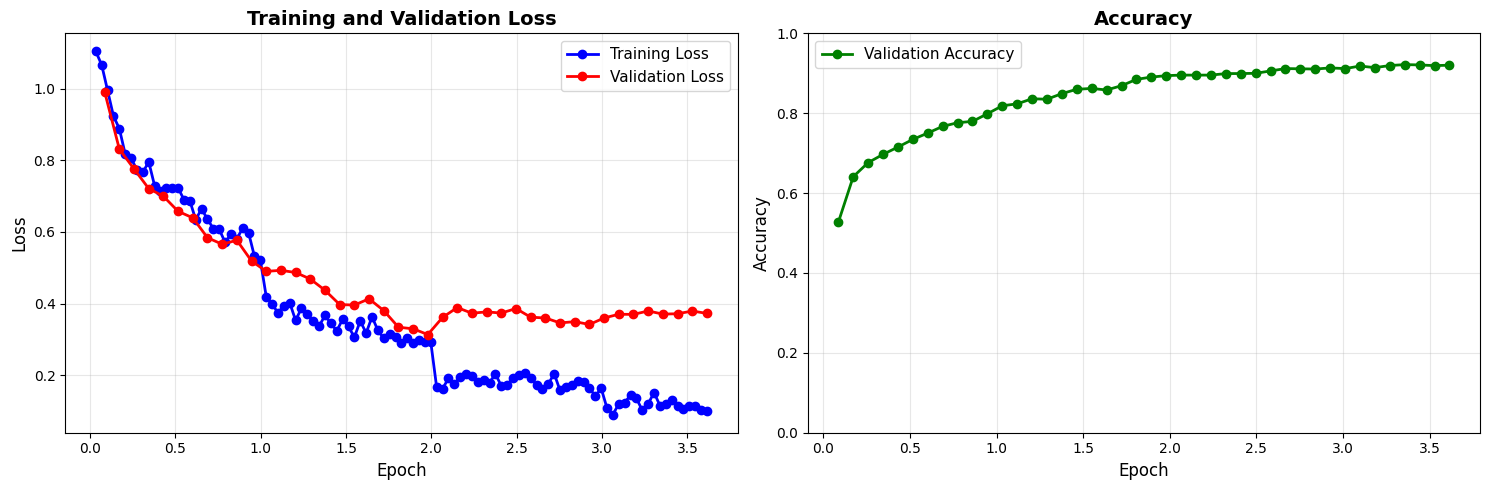

In [28]:
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
if train_losses and eval_losses:
    plt.plot(epochs_train, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
    plt.plot(epochs_eval, eval_losses, 'r-o', label='Validation Loss', linewidth=2, markersize=6)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
if train_accuracies:
    plt.plot(epochs_train[:len(train_accuracies)], train_accuracies, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
if eval_accuracies:
    plt.plot(epochs_eval, eval_accuracies, 'g-o', label='Validation Accuracy', linewidth=2, markersize=6)
plt.title('Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


In [17]:
# Classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_,
    digits=4
))



CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative     0.9217    0.9275    0.9245      4287
     neutral     0.9267    0.9154    0.9210      3465
    positive     0.9174    0.9209    0.9191      3869

    accuracy                         0.9217     11621
   macro avg     0.9219    0.9213    0.9216     11621
weighted avg     0.9217    0.9217    0.9217     11621



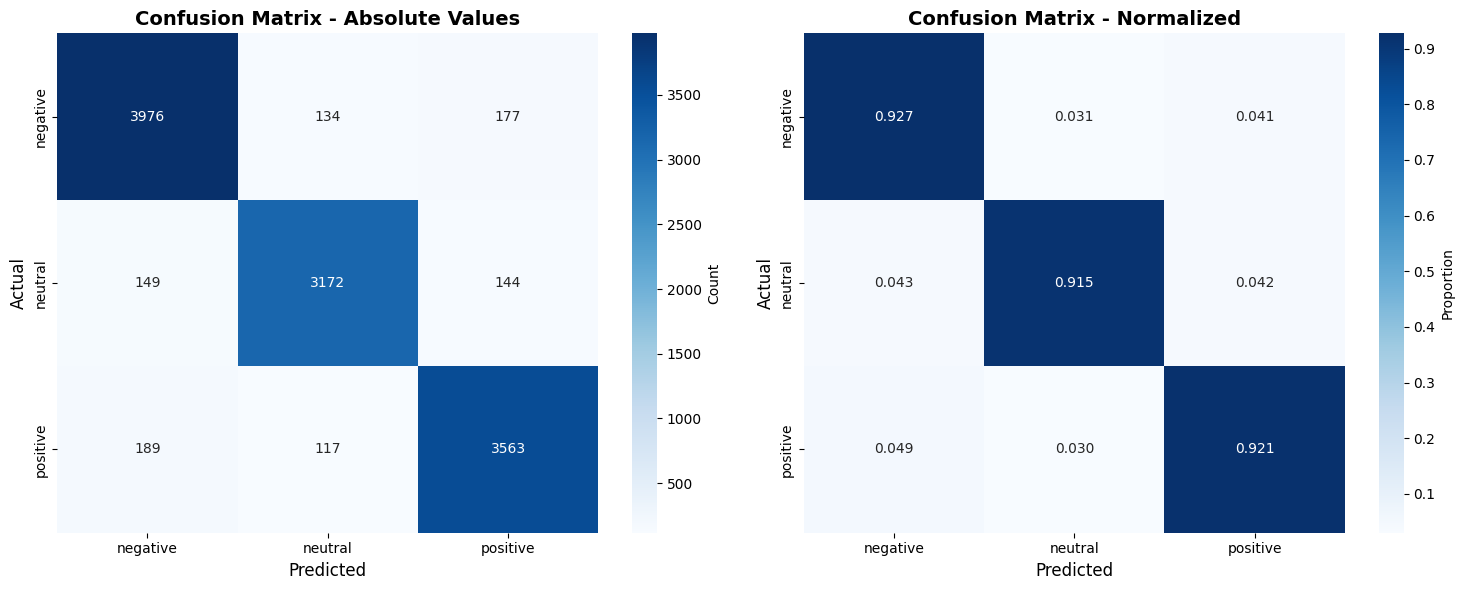

In [18]:
plt.figure(figsize=(15, 6))
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Absolute confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Absolute Values', fontsize=14, fontweight='bold')

# Normalized confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_norm, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Normalized', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [19]:
print("\n" + "="*50)
print("PER-CLASS ANALYSIS")
print("="*50)
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
        class_count = np.sum(class_mask)
        print(f"{class_name.capitalize():>10}: Accuracy={class_accuracy:.4f}, Count={class_count}")



PER-CLASS ANALYSIS
  Negative: Accuracy=0.9275, Count=4287
   Neutral: Accuracy=0.9154, Count=3465
  Positive: Accuracy=0.9209, Count=3869
